# Linear regression


$$
\begin{align*}
    \log \sigma &\sim \text{Gaussian}(0, 1)\\
    \beta_j &\sim \text{Gaussian}(0, 1) \\
    \mu_i &= \beta_0 + \beta_1 x_i \\
    y_{i} &\sim \text{Gaussian}\left(\mu_i, \sigma^2\right) \enspace,
\end{align*}
$$

where $i=1, \ldots, n$ are the number of observations.


_Note: tuning the parameters of Hamiltonian Monte Carlo turned out to be very unstable; hence HMC has been omitted from this example._

In [1]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = '0'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [0]


In [2]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import blackjax

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from distrax._src.distributions.distribution import Distribution
from distrax._src.bijectors.bijector import Bijector

import os
import sys

from blackjax import normal_random_walk, hmc, nuts, elliptical_slice
from blackjax.diagnostics import potential_scale_reduction, effective_sample_size

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../../')))

from bamojax.base import Node, Model
from bamojax.sampling import gibbs_sampler, inference_loop, run_chain, smc_inference_loop


print('Python version:     ', sys.version)
print('Jax version:        ', jax.__version__)
print('BlackJax version:   ', blackjax.__version__)
print('Distrax version:    ', dx.__version__)
print('Jax default backend:', jax.default_backend())
print('Jax devices:        ', jax.devices())

Python version:      3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
Jax version:         0.4.35
BlackJax version:    1.2.4
Distrax version:     0.1.5
Jax default backend: gpu
Jax devices:         [CudaDevice(id=0)]


Construct the model and add link functions where required. This is also needed for the Bernoulli distribution, as in distrax it can be parametrized either by probabilities or their logits, and it needs to be passed as an explicit keyword which of the two is used.

Gibbs conditionals: 
Gibbs structure:
beta                : p(y | x, sigma, beta) p(beta)
sigma               : p(y | x, sigma, beta) p(sigma)


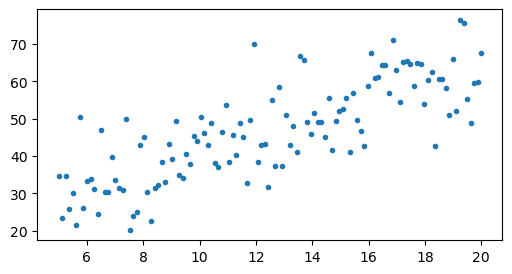

In [3]:
key = jrnd.PRNGKey(42)
key, key_data = jrnd.split(key)

b_true = [17., 2.3]
sigma_true = 8.0

n = 120

x = jnp.linspace(5, 20, n)

mu = b_true[0] + b_true[1]*x

y = mu + sigma_true*jrnd.normal(key_data, shape=(n, ))

plt.figure(figsize=(6, 3))
ax = plt.gca()
ax.plot(x, y, '.')

def lin_reg_link_fn(beta, sigma, x):
    mu = beta[0] + beta[1]*x
    return dict(loc=mu, scale=sigma)

LinearRegression = Model('BLR')
sigma = LinearRegression.add_node('sigma', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
beta = LinearRegression.add_node('beta', distribution=dx.Normal(loc=0., scale=1.), shape=(2, ))
x = LinearRegression.add_node('x', observations=x)
y = LinearRegression.add_node('y', observations=y, distribution=dx.Normal, parents=dict(beta=beta, sigma=sigma, x=x), link_fn=lin_reg_link_fn)

print('Gibbs conditionals: ')
LinearRegression.print_gibbs()

Plotting functions for the toy model posterior:

In [4]:
def plot_states(position, color, title):

    fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(18, 3))
    for j in range(2):
        ax = axes[j]
        ax.hist(position['beta'][:, j], density=True, bins=30, facecolor=color, edgecolor='k')
        ax.axvline(x=b_true[j], color='k', ls='--')
        ax.set_xlabel(fr'$\beta_{{{j}}}$')

    ax = axes[2]
    ax.hist(position['sigma'].flatten(), bins=30,  density=True, facecolor=color, edgecolor='k');
    ax.axvline(x=sigma_true, ls='--', color='k')
    ax.set_xlabel(r'$\sigma$')

    plt.suptitle(title)
    return fig, axes

#

## Standard MCMC

### RMH

Acceptance rate: 0.897
CPU times: user 7.41 s, sys: 2.51 s, total: 9.93 s
Wall time: 9.96 s


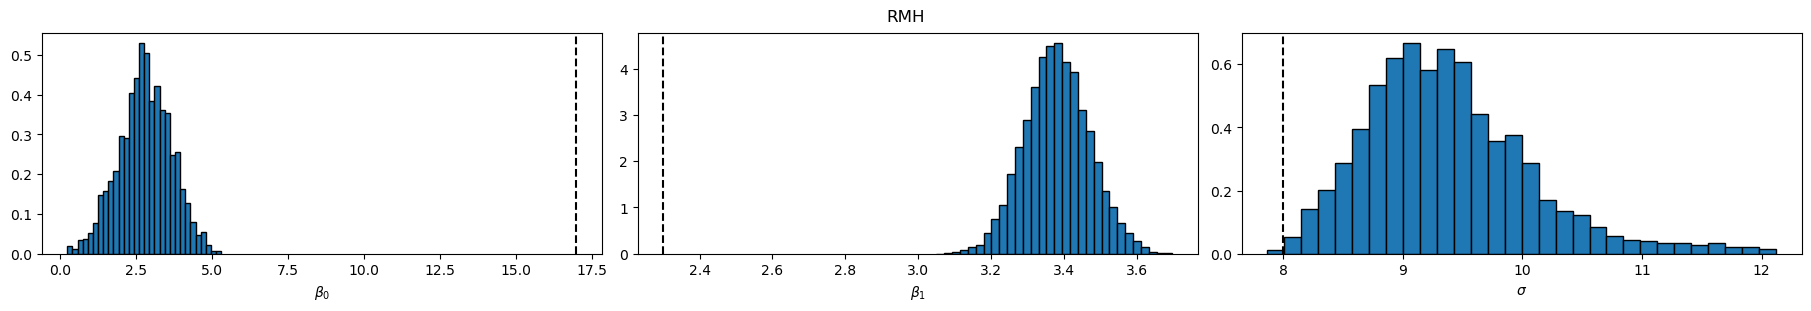

In [5]:
%%time

logdensity_fn = lambda state: LinearRegression.loglikelihood_fn()(state) + LinearRegression.logprior_fn()(state)
rmh = normal_random_walk(logdensity_fn, sigma=0.02*jnp.eye(LinearRegression.get_model_size()))

num_samples = 100_000
num_burn = 100_000
num_thin = 5
num_chains = 1

key, subkey = jrnd.split(key)
rmh_states, rmh_info = inference_loop(subkey, model=LinearRegression, kernel=rmh, num_samples=num_samples, num_burn=num_burn, num_chains=num_chains, num_thin=num_thin)

_ = plot_states(rmh_states.position, color='tab:blue', title='RMH')

print(f'Acceptance rate: {jnp.mean(1.0*rmh_info.is_accepted):0.3f}')

### NUTS MCMC

Including window adaptation (gold standard).

Todo: add initial states to the inference loop (i.e., post warm-up)

warm parameters {'step_size': Array(0.56772164, dtype=float64, weak_type=True), 'inverse_mass_matrix': Array([0.85784915, 0.00805036, 0.37044969], dtype=float64)}
CPU times: user 13.6 s, sys: 400 ms, total: 14 s
Wall time: 12.6 s


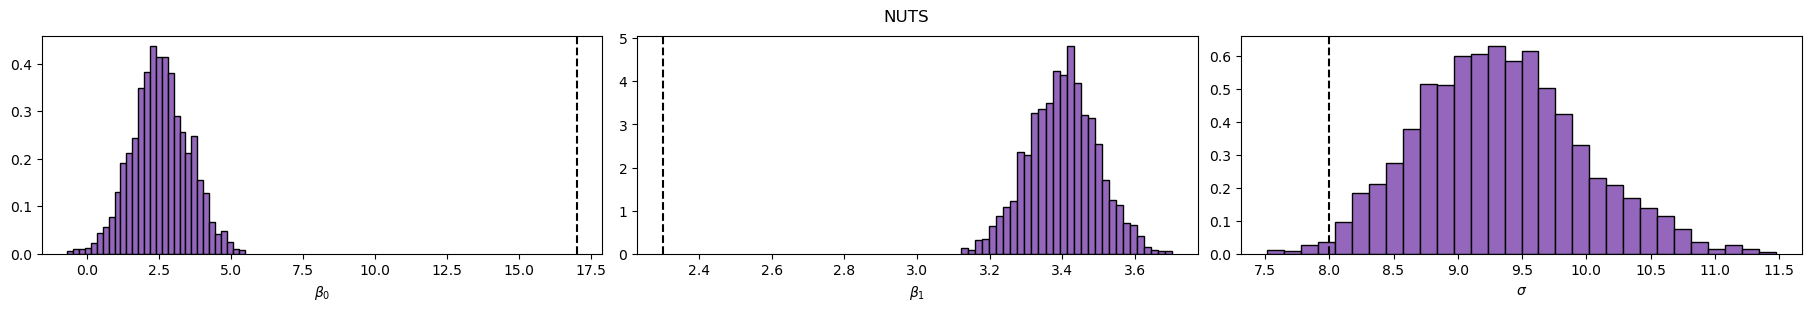

In [6]:
%%time

key, k_init, k_warmup, k_mcmc = jrnd.split(key, 4)

num_samples = 2000
num_burn = 500
num_thin = 1

logdensity_fn = lambda state: LinearRegression.loglikelihood_fn()(state) + LinearRegression.logprior_fn()(state)

warmup = blackjax.window_adaptation(nuts, logdensity_fn)
(warm_state, warm_parameters), _ = warmup.run(k_warmup, LinearRegression.sample_prior(k_init), num_steps=num_burn)  # technically this isn't the burn-in, but it's usable as such
print('warm parameters', warm_parameters)

nuts_kernel = nuts(logdensity_fn, **warm_parameters)

nuts_states, nuts_info = run_chain(k_mcmc, kernel=nuts_kernel.step, initial_state=warm_state, num_samples=num_burn+num_samples)
nuts_states = jax.tree_util.tree_map(lambda x: x[num_burn::num_thin, ...], nuts_states)

_ = plot_states(nuts_states.position, color='tab:purple', title='NUTS')

### Gibbs MCMC

The Gibbs conditionals are derived automatically by BaMoJax.

Acceptance rate for beta: 0.574
Acceptance rate for sigma: 0.744
CPU times: user 6.41 s, sys: 2.48 s, total: 8.89 s
Wall time: 8.09 s


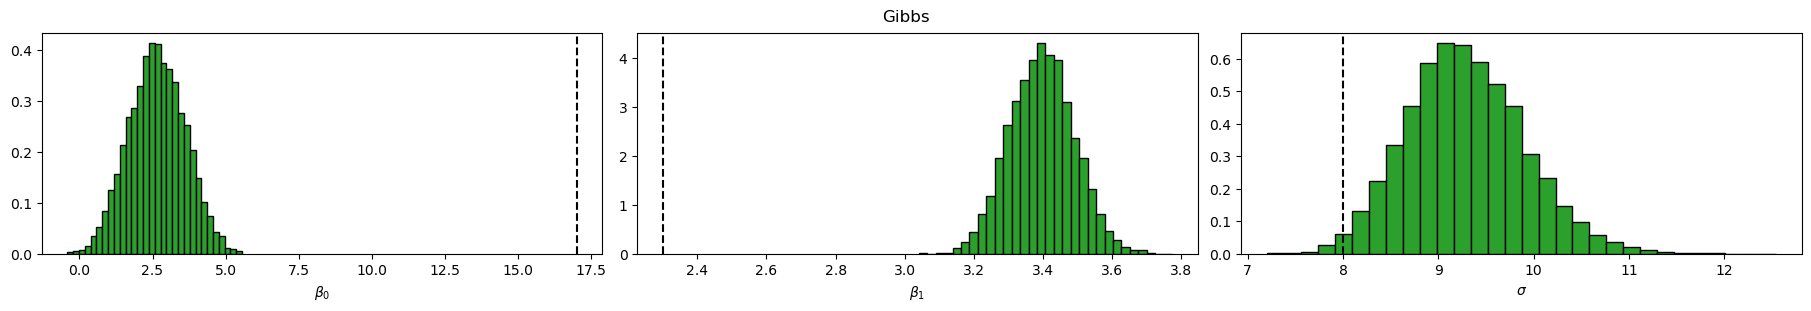

In [7]:
%%time

step_fns = dict(beta=normal_random_walk, sigma=normal_random_walk)
step_fn_params = dict(beta=dict(sigma=0.1), sigma=dict(sigma=0.5))

gibbs = gibbs_sampler(LinearRegression, step_fns=step_fns, step_fn_params=step_fn_params)

num_samples = 50_000
num_burn = 50_000
num_thin = 5
num_chains = 1

key, subkey = jrnd.split(key)

gibbs_states, gibbs_info = inference_loop(subkey, model=LinearRegression, kernel=gibbs, num_samples=num_samples, num_burn=num_burn, num_chains=num_chains, num_thin=num_thin)

_ = plot_states(gibbs_states.position, color='tab:green', title='Gibbs')

for node in gibbs_info:
    print(f'Acceptance rate for {node}: {jnp.mean(gibbs_info[node].is_accepted):0.3f}')

# Target acceptance rate for 1D: 0.4, target for ND: 0.234

## Gibbs-in-SMC

Acceptance rate for beta: 0.758
Acceptance rate for sigma: 0.893
CPU times: user 9.21 s, sys: 381 ms, total: 9.59 s
Wall time: 6.69 s


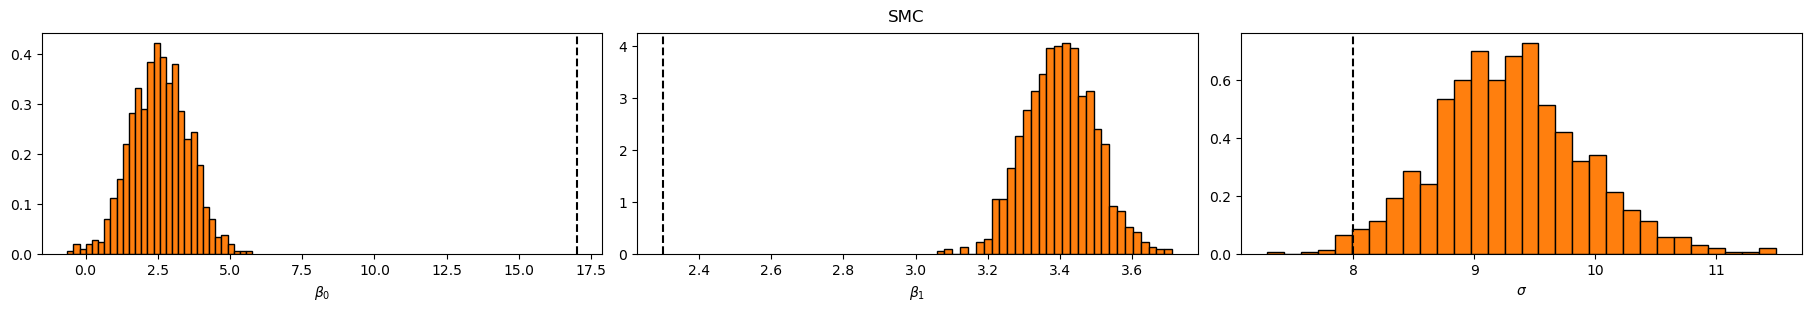

In [18]:
%%time

num_mcmc_steps = 100
num_particles = 1_000

step_fns = dict(beta=normal_random_walk, sigma=normal_random_walk)
step_fn_params = dict(beta=dict(sigma=0.05), sigma=dict(sigma=0.2))

gibbs = gibbs_sampler(LinearRegression, step_fns=step_fns, step_fn_params=step_fn_params)

key, subkey = jrnd.split(key)

final_state, lml, n_iter, final_info = smc_inference_loop(subkey, model=LinearRegression, kernel=gibbs, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

_ = plot_states(final_state.particles, color='tab:orange', title='SMC')

for theta in ['beta', 'sigma']:
    print(f'Acceptance rate for {theta}: {jnp.mean(final_info.update_info[theta].is_accepted):0.3f}')

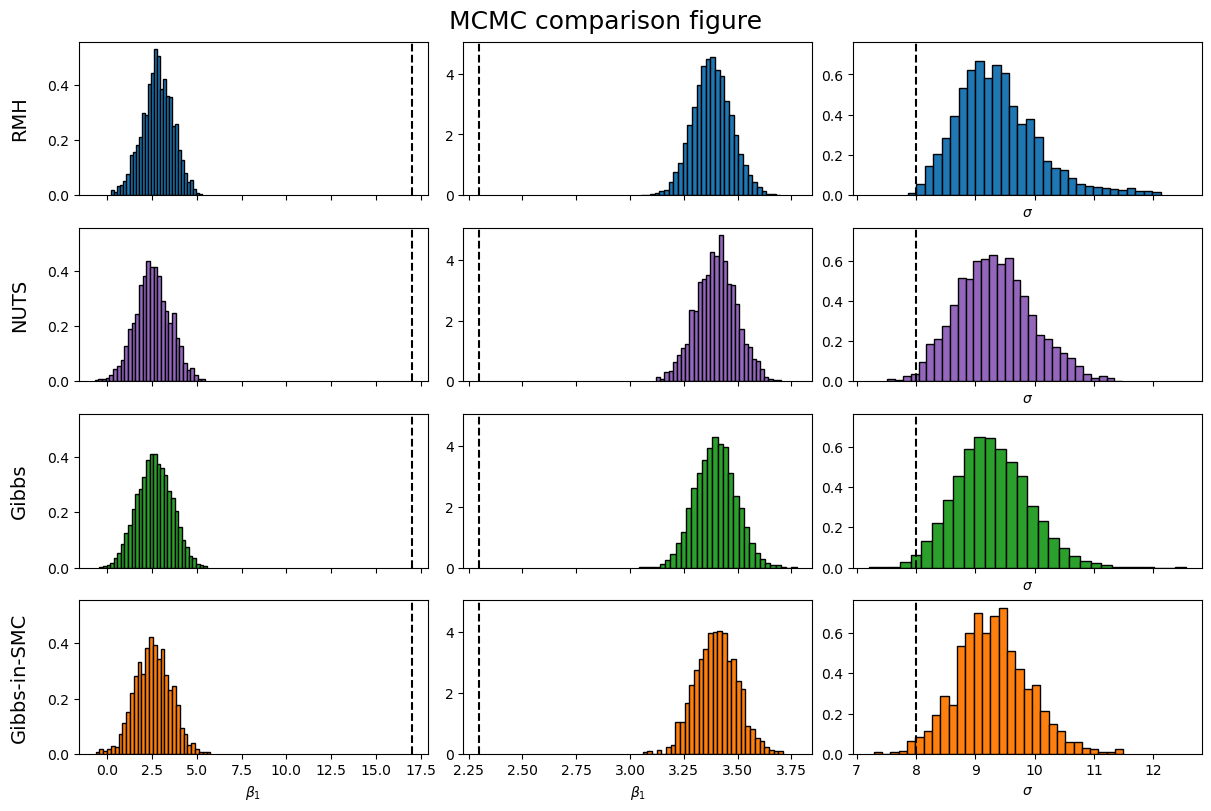

In [19]:
states = [rmh_states.position, nuts_states.position, gibbs_states.position, final_state.particles]
colors = ['tab:blue', 'tab:purple', 'tab:green', 'tab:orange']
names = ['RMH', 'NUTS', 'Gibbs', 'Gibbs-in-SMC']

n_methods = len(names)

_, axes = plt.subplots(nrows=n_methods, ncols=3, constrained_layout=True, figsize=(12, 2*n_methods), sharey='col', sharex='col')

for i in range(n_methods):

    for j in range(2):
        ax = axes[i, j]
        ax.hist(states[i]['beta'][:, j], density=True, bins=30, facecolor=colors[i], edgecolor='k')
        ax.axvline(x=b_true[j], color='k', ls='--')

    ax = axes[i, 2]
    ax.hist(states[i]['sigma'].flatten(), bins=30,  density=True, facecolor=colors[i], edgecolor='k');
    ax.axvline(x=sigma_true, ls='--', color='k')
    ax.set_xlabel(r'$\sigma$')

pad = 5
for i, ax in enumerate(axes[:, 0]):
    ax.annotate(names[i], xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0), xycoords=ax.yaxis.label, textcoords='offset points', size=14, ha='right', va='center', rotation=90)

for ax in axes[-1, [0, 1]]:
    ax.set_xlabel(fr'$\beta_{{{j}}}$')
plt.suptitle('MCMC comparison figure', fontsize=18);